# Data Training
The training process is conducted using TensorFlow, with a convolutional neural network (CNN) model as the foundation. Hyperparameter tracking is managed through Weights & Biases (WandB), while model versioning is implemented via Hugging Face Hub. The initial model is developed using a vanilla CNN architecture, chosen for its simplicity and effectiveness in hypothetical scenarios.

### Import the necesary package

In [1]:
# handling paths
import os
# tracking the training hyperparameters and logs
import wandb
# custom script (store the data loading and preprocessing functions)
import utilities as ut
# handle data visualization
import matplotlib.pyplot as plt
# model versioning
from huggingface_hub import HfApi
# deep learning libraries for training the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
from tensorflow.keras.callbacks import Callback, EarlyStopping

d:\Programming\Python\Env_storage\ml_venv_3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialize the needed variables
initiate the variables to make the change of hyperparameter and configuration easier

In [2]:
# the path to the dataset
path_dataset = {
    "train": "./dataset/augmented_dataset/train",
    "test": "./dataset/splited_dataset/test",
}
# the hyperparameters of the model
hyperparameters = {
    "augmentation": True,
    "image_size": (128, 128),
    "batch_size": 64,
    "epochs": 10,
    "learning_rate": None,
    "optimizer": "adam",
    "loss": "sparse_categorical_crossentropy",
    "metrics": ["accuracy"],
    "model_structure": {
        "conv": 1,
        "pool": 1,
        "batchnorm": 1,
        "dropout": 0,
        "dense": 2},
}
# the optimizer map
optimizer_map = {
    "adam": Adam(),
    "sgd": SGD(),
    "rmsprop": RMSprop(),
    "adamax": Adamax(),
}
labels = os.listdir(path_dataset["train"])
commit_message = "reduce the batch size and reduce the model complexity"
wandb_init_name = "reduce-batch-size"

### Get the dataset
Load and preprocess the dataset using custom scripts

In [3]:
# get all the images path
path_imgs_train = ut.get_imgs_path(path_dataset["train"], labels)
path_imgs_test = ut.get_imgs_path(path_dataset["test"], labels)

In [4]:
# create the batched and already preprocessed dataset
trainset = ut.create_dataset(path_imgs_train, hyperparameters["image_size"], hyperparameters["batch_size"])
testset = ut.create_dataset(path_imgs_test, hyperparameters["image_size"], hyperparameters["batch_size"])

### Show the sample image
show the sample image from the batched datasett

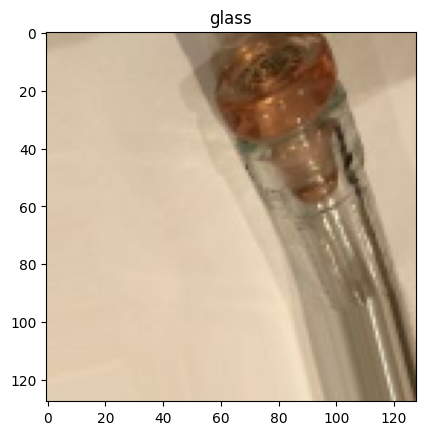

In [5]:
for img, label in trainset.take(1):
    plt.imshow(img[0].numpy())
    plt.title(labels[label[0]])
    plt.show()

### Connect wandb
initialize the wandb to connect and set the config to the current hyperparameters

In [6]:
wandb.init(project="trash-classification",
            name=wandb_init_name,
            config=hyperparameters)
config = wandb.config

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bugi-sulistiyo (bugi-sulistiyo-universitas-mulawarman). Use `wandb login --relogin` to force relogin


### Create the model
the model is created from simple the complex. batch normalization is used to make the value more stable and dropout layer also added to help batch normalization prevent overfitting

In [7]:
model = Sequential([
    # conv layer 1
    Conv2D(16, (3, 3), activation="relu", input_shape=(config.image_size[0], config.image_size[1], 3)),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    # conv layer 2
    # Conv2D(32, (3, 3), activation="relu"),
    # BatchNormalization(),
    # MaxPool2D((2, 2)),
    # Conv2D(64, (3, 3), activation="relu"),
    # BatchNormalization(),
    # MaxPool2D((2, 2)),
    # flatten the output
    Flatten(),
    # dense layer 1
    Dense(32, activation="relu"),
    # dropout layer
    # Dropout(0.3),
    # output layer
    Dense(len(path_imgs_train.label.unique()), activation="softmax")
])

d:\Programming\Python\Env_storage\ml_venv_3.11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model config
configure the model with the defined hyperparameter and create a wandb callback

In [8]:
model.compile(
    optimizer=optimizer_map[config.optimizer],
    loss=config.loss,
    metrics=config.metrics
)
class CustomWandbCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

### Model training
Train the model with test set as validationset

In [9]:
model.fit(
    trainset,
    validation_data=testset,
    epochs=config.epochs,
    callbacks=[CustomWandbCallback(), early_stopping]
)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.3650 - loss: 2.6052 - val_accuracy: 0.1988 - val_loss: 1.7171
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.4962 - loss: 1.2967 - val_accuracy: 0.2641 - val_loss: 1.6463
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.6002 - loss: 1.0072 - val_accuracy: 0.3709 - val_loss: 1.7770
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.6963 - loss: 0.7918 - val_accuracy: 0.5183 - val_loss: 1.5710
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.7690 - loss: 0.5999 - val_accuracy: 0.4599 - val_loss: 1.9160
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8372 - loss: 0.4287 - val_accuracy: 0.5035 - val_loss: 2.3051
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8796 - loss: 0.3245 - val_accuracy: 0.4342 - val_loss: 3.9841


### Save the model
The model is saved in form of .h5 and .keras. also, capture the log artifact

In [10]:
model.save("model/vanila_cnn.h5")
model.save("model/vanila_cnn.keras")
wandb.log_artifact("model/vanila_cnn.h5", type="model")
wandb.finish()

accuracy,▁▃▄▅▆▇█
loss,█▅▄▃▂▁▁
val_accuracy,▁▂▅█▇█▆
val_loss,▁▁▂▁▂▃█
accuracy,0.87742
loss,0.33321
val_accuracy,0.43422
val_loss,3.98412


### Capture model version
upload the model to hugging face

In [11]:
api = HfApi()
repo = api.create_repo("trash-classification", repo_type="model", exist_ok=True)
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj="model/vanila_cnn.h5",
    path_in_repo="model/vanila_cnn.h5",
    repo_type=repo.repo_type,
    commit_message=f".h5 file - {commit_message}"
)
api.upload_file(
    repo_id=repo.repo_id,
    path_or_fileobj="model/vanila_cnn.keras",
    path_in_repo="model/vanila_cnn.keras",
    repo_type=repo.repo_type,
    commit_message=f".keras - {commit_message}"
)

vanila_cnn.h5: 100%|██████████| 24.4M/24.4M [00:16<00:00, 1.49MB/s]
vanila_cnn.keras: 100%|██████████| 24.4M/24.4M [00:15<00:00, 1.55MB/s]


CommitInfo(commit_url='https://huggingface.co/bugi-sulistiyo/trash-classification/commit/584df72a878aa356805efa9bf39464afe42273ab', commit_message='.keras - reduce the batch size and reduce the model complexity', commit_description='', oid='584df72a878aa356805efa9bf39464afe42273ab', pr_url=None, repo_url=RepoUrl('https://huggingface.co/bugi-sulistiyo/trash-classification', endpoint='https://huggingface.co', repo_type='model', repo_id='bugi-sulistiyo/trash-classification'), pr_revision=None, pr_num=None)